### Notebook for creating the feature engineering for the sleep datasets from OURA.

First, let's ingest the data saved on our most recent folder:

This notebook steps through the dataset and several feature engineering ideas.

In [2]:
import json
import numpy as np
import pandas as pd # obs.: this nb was made using pandas 0.20.3 - I will ignore some deprecation warnings for now (like the one for rolling_mean())
import pprint as pp
import os
from os import mkdir
from os import chdir
from zipfile import ZipFile
from datetime import datetime,date
import time
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


Bad key "changing the colors used" on line 1 in
/Users/marceloqueiroz/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/marcelo_style_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/Users/marceloqueiroz/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Ingestion and duplicated variables handling

In [3]:
with ZipFile('data_ingestion/15092019/dataset.zip') as myzip:
    with myzip.open('sleep_data.csv') as myfile:
        sleep_df = pd.read_csv(myfile)
    with myzip.open('users_data.csv') as myfile:
        user_df = pd.read_csv(myfile)

print('---- SLEEP DATAFRAME SHAPE:', sleep_df.shape, ' - COLUMNS: ----')
print(sleep_df.columns, '\n')
print('---- USERS DATAFRAME COLUMNS', user_df.shape, ' - COLUMNS: ----')
print(user_df.columns)

---- SLEEP DATAFRAME SHAPE: (14644, 38)  - COLUMNS: ----
Index(['awake', 'bedtime_end', 'bedtime_end_delta', 'bedtime_start',
       'bedtime_start_delta', 'breath_average', 'deep', 'duration',
       'efficiency', 'hr_5min', 'hr_average', 'hr_lowest', 'hypnogram_5min',
       'is_longest', 'light', 'midpoint_at_delta', 'midpoint_time',
       'onset_latency', 'period_id', 'rem', 'restless', 'rmssd', 'rmssd_5min',
       'score', 'score_alignment', 'score_deep', 'score_disturbances',
       'score_efficiency', 'score_latency', 'score_rem', 'score_total',
       'summary_date', 'temperature_delta', 'temperature_deviation',
       'temperature_trend_deviation', 'timezone', 'total', 'user_id'],
      dtype='object') 

---- USERS DATAFRAME COLUMNS (59, 6)  - COLUMNS: ----
Index(['age', 'email', 'gender', 'height', 'user_id', 'weight'], dtype='object')


In [4]:
# check for NaN in user_df:
user_df.isnull().sum()

age        12
email       1
gender     14
height     12
user_id     0
weight     12
dtype: int64

In [5]:
# check for duplicates in users DF:
user_df.drop_duplicates(inplace=True)
user_df.shape

(57, 6)

Now, merging the user and sleep DFs into one:

In [6]:
# let's drop email for anonimization purposes:
user_df.drop(['email'], axis=1, inplace=True)
df = sleep_df.set_index('user_id').join(user_df.set_index('user_id'))

# now lets concatenate the user_id and the summary date to have a unique index for each observation:
df['user_date'] = df.index.map(str) + '_' + df['summary_date']

df.reset_index(inplace=True)
df.keys()

Index(['user_id', 'awake', 'bedtime_end', 'bedtime_end_delta', 'bedtime_start',
       'bedtime_start_delta', 'breath_average', 'deep', 'duration',
       'efficiency', 'hr_5min', 'hr_average', 'hr_lowest', 'hypnogram_5min',
       'is_longest', 'light', 'midpoint_at_delta', 'midpoint_time',
       'onset_latency', 'period_id', 'rem', 'restless', 'rmssd', 'rmssd_5min',
       'score', 'score_alignment', 'score_deep', 'score_disturbances',
       'score_efficiency', 'score_latency', 'score_rem', 'score_total',
       'summary_date', 'temperature_delta', 'temperature_deviation',
       'temperature_trend_deviation', 'timezone', 'total', 'age', 'gender',
       'height', 'weight', 'user_date'],
      dtype='object')

In [7]:
df.shape

(14644, 43)

Let's check if there are fully duplicated rows:

In [8]:
df[df.duplicated(subset='user_date')][['user_date','bedtime_start', 'bedtime_end', 'summary_date', 'period_id', 'is_longest', 'score']].shape

(450, 7)

In [9]:
df[df.duplicated(subset='user_date')][['user_date','bedtime_start', 'bedtime_end', 'summary_date', 'period_id', 'is_longest', 'score']].head()

,user_date,bedtime_start,bedtime_end,summary_date,period_id,is_longest,score
11269,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-01-22,2019-01-22T22:31:27-05:00,2019-01-23T07:49:27-05:00,2019-01-22,0,1,86
11270,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-01-23,2019-01-24T00:56:31-05:00,2019-01-24T10:59:31-05:00,2019-01-23,0,1,68
11271,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-01-24,2019-01-25T02:45:33-05:00,2019-01-25T11:59:33-05:00,2019-01-24,0,1,76
11272,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-01-25,2019-01-26T00:24:08-05:00,2019-01-26T09:40:08-05:00,2019-01-25,1,1,77
11273,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-01-26,2019-01-27T02:06:33-05:00,2019-01-27T11:45:33-05:00,2019-01-26,0,1,67


In [10]:
df[df.duplicated(subset='user_date')][['user_date','bedtime_start', 'bedtime_end', 'summary_date', 'period_id', 'is_longest', 'score']].tail()


,user_date,bedtime_start,bedtime_end,summary_date,period_id,is_longest,score
11714,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-09-09,2019-09-10T02:04:02-04:00,2019-09-10T10:00:02-04:00,2019-09-09,0,1,61
11715,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-09-10,2019-09-11T04:39:05-04:00,2019-09-11T11:27:05-04:00,2019-09-10,0,1,53
11716,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-09-11,2019-09-12T02:06:01-04:00,2019-09-12T11:05:01-04:00,2019-09-11,1,1,60
11717,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-09-12,2019-09-13T03:19:59-04:00,2019-09-13T12:19:59-04:00,2019-09-12,0,1,71
11718,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-09-13,2019-09-14T02:42:56-04:00,2019-09-14T12:18:56-04:00,2019-09-13,0,1,69


As this are from the same user (in the head and the tail of the duplicated `df`), the case is possibly we have the same user logging his data under two accounts.

In [11]:
df[df['user_date']=='RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-01-24']

,user_id,awake,bedtime_end,bedtime_end_delta,bedtime_start,bedtime_start_delta,breath_average,deep,duration,efficiency,...,temperature_delta,temperature_deviation,temperature_trend_deviation,timezone,total,age,gender,height,weight,user_date
11046,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM,5700,2019-01-25T11:59:33-05:00,43173,2019-01-25T02:45:33-05:00,9933,16.125,3120,33240,83,...,-0.03,-0.03,0.0,-300,27540,21.0,male,175.0,68.0,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-01-24
11271,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM,5700,2019-01-25T11:59:33-05:00,43173,2019-01-25T02:45:33-05:00,9933,16.125,3120,33240,83,...,-0.03,-0.03,0.0,-300,27540,21.0,male,175.0,68.0,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-01-24
11496,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM,5700,2019-01-25T11:59:33-05:00,43173,2019-01-25T02:45:33-05:00,9933,16.125,3120,33240,83,...,-0.03,-0.03,0.0,-300,27540,21.0,male,175.0,68.0,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-01-24


In fact under three accounts, which tells it's true due to the identical rows. So I will delete total duplicates:

In [12]:
df.drop_duplicates(inplace=True)
df.shape

(14194, 43)

## Naps and Longer Sleep periods

Now let's analyze the naps the users takes during the day:

In [13]:
df[df['is_longest'] == 0]

,user_id,awake,bedtime_end,bedtime_end_delta,bedtime_start,bedtime_start_delta,breath_average,deep,duration,efficiency,...,temperature_delta,temperature_deviation,temperature_trend_deviation,timezone,total,age,gender,height,weight,user_date
4854,FYA4OXP4Z2K7TRL2PWHJVUA6DW2ZX2FZ,1950,2019-02-17T16:23:58Z,59038,2019-02-17T15:38:58Z,56338,17.625,0,2700,28,...,NaN,NaN,NaN,0,750,50.0,male,180.0,81.6,FYA4OXP4Z2K7TRL2PWHJVUA6DW2ZX2FZ_2019-02-16
7993,LIQI5SGSWLLF2PWAG37HVERU3IQ56YNC,3060,2019-02-17T06:39:33-06:00,23973,2019-02-16T21:43:33-06:00,-8187,13.625,930,32160,90,...,NaN,NaN,NaN,-360,29100,62.0,female,147.0,50.0,LIQI5SGSWLLF2PWAG37HVERU3IQ56YNC_2019-02-16
8009,LIQI5SGSWLLF2PWAG37HVERU3IQ56YNC,1620,2019-03-05T05:59:29-06:00,21569,2019-03-04T21:53:29-06:00,-7591,15.000,4290,29160,94,...,NaN,NaN,NaN,-360,27540,62.0,female,147.0,50.0,LIQI5SGSWLLF2PWAG37HVERU3IQ56YNC_2019-03-04
8243,M66MESIGOACKFG6HV7A4RFOWUZ7WWGIO,4350,2019-06-20T06:52:20-07:00,24740,2019-06-19T23:03:20-07:00,-3400,13.250,8010,28140,85,...,NaN,NaN,NaN,-420,23790,35.0,male,185.0,87.1,M66MESIGOACKFG6HV7A4RFOWUZ7WWGIO_2019-06-19
13362,TNW7YYC4H2VYZRDXQRTHMGQJZSSUHM6X,3810,2019-07-24T09:40:02+02:00,34802,2019-07-24T06:39:02+02:00,23942,13.000,1020,10860,65,...,NaN,NaN,NaN,120,7050,34.0,male,178.0,80.3,TNW7YYC4H2VYZRDXQRTHMGQJZSSUHM6X_2019-07-23


In [14]:
df.iloc[4854:4856]

,user_id,awake,bedtime_end,bedtime_end_delta,bedtime_start,bedtime_start_delta,breath_average,deep,duration,efficiency,...,temperature_delta,temperature_deviation,temperature_trend_deviation,timezone,total,age,gender,height,weight,user_date
4854,FYA4OXP4Z2K7TRL2PWHJVUA6DW2ZX2FZ,1950,2019-02-17T16:23:58Z,59038,2019-02-17T15:38:58Z,56338,17.625,0,2700,28,...,NaN,NaN,NaN,0,750,50.0,male,180.0,81.6,FYA4OXP4Z2K7TRL2PWHJVUA6DW2ZX2FZ_2019-02-16
4855,FYA4OXP4Z2K7TRL2PWHJVUA6DW2ZX2FZ,5220,2019-02-18T07:07:37Z,25657,2019-02-17T23:01:37Z,-3503,16.875,4980,29160,82,...,0.19,0.19,0.21,0,23940,50.0,male,180.0,81.6,FYA4OXP4Z2K7TRL2PWHJVUA6DW2ZX2FZ_2019-02-17


### Note:
Now it is interesting to note that Oura has the capabilities to measure naps during the day. The way to differentiate that is using feature `is_longest`, however only 5 rows were not the longest of the user in a given day in our dataset, and when analyzing some the cases, they are at least inconsistent. For that reason I reached out to the responsible for the data pipeline and until further notice will drop the observations where `is_longest` = 0.

In [15]:
df = df[df['is_longest'] != 0]

Finally, let's add some units to the feature names and transform the types so we can properly work on the numerical and date types:

In [16]:
num_types = ['age', 'awake', 'bedtime_end_delta','bedtime_start_delta','breath_average','breath_average',
             'deep', 'duration', 'efficiency', 'height', 'hr_average', 'hr_lowest','light', 
             'midpoint_at_delta', 'midpoint_time', 'onset_latency', 'period_id', 'rem', 'restless',
             'rmssd', 'score', 'score_alignment', 'score_deep', 'score_disturbances', 'score_efficiency',
             'score_latency', 'score_rem', 'score_total', 'temperature_delta', 'temperature_deviation',
             'temperature_trend_deviation', 'timezone', 'total', 'weight' ]

# not converting bedtime_end and bedtime_start to avoid dealing with timezones.
# additionally, bedtime_end_delta and bedtime_start_delta represents the respective
# from 00:00, which we will use later. The UTC timezone is stored in a separate feature.
date_types = ['summary_date']

all_columns_with_units =  ['user_id[str]','awake[s]', 'bedtime_end[str]', 'bedtime_end_delta[s]', 'bedtime_start[str]',
                           'bedtime_start_delta[s]', 'breath_average[breath/min]', 'deep[s]', 'duration[s]',
                           'efficiency[%]', 'hr_5min[bpm]', 'hr_average[bpm]', 'hr_lowest[bpm]',
                           'hypnogram_5min[str]', 'is_longest[bool]', 'light[s]', 'midpoint_at_delta[s]',
                           'midpoint_time[s]', 'onset_latency[s]', 'period_id[int]', 'rem[s]', 'restless[%]',
                           'rmssd[ms]', 'rmssd_5min[bpm]', 'score[%]', 'score_alignment[%]', 'score_deep[%]',
                           'score_disturbances[%]', 'score_efficiency[%]', 'score_latency[%]', 'score_rem[%]',
                           'score_total[%]', 'summary_date[t]', 'temperature_delta[C]',
                           'temperature_deviation[C]', 'temperature_trend_deviation[C]', 'timezone[s]',
                           'total[s]', 'age[y]', 'gender', 'height[cm]', 'weight[kg]', 'user_date[str]']

df[num_types] = df[num_types].apply(pd.to_numeric)
df[date_types] = df[date_types].apply(pd.to_datetime)

df.columns = all_columns_with_units

In [17]:
df.head()

,user_id[str],awake[s],bedtime_end[str],bedtime_end_delta[s],bedtime_start[str],bedtime_start_delta[s],breath_average[breath/min],deep[s],duration[s],efficiency[%],...,temperature_delta[C],temperature_deviation[C],temperature_trend_deviation[C],timezone[s],total[s],age[y],gender,height[cm],weight[kg],user_date[str]
0,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4,4380,2018-10-12T12:28:03+01:00,44883,2018-10-12T03:35:03+01:00,12903,14.750,7200,31980,86,...,-0.53,-0.53,NaN,60,27600,NaN,NaN,NaN,NaN,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4_2018-10-11
1,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4,6810,2018-10-13T12:20:18+02:00,44418,2018-10-13T03:10:18+02:00,11418,15.250,5700,33000,79,...,0.14,0.14,0.40,120,26190,NaN,NaN,NaN,NaN,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4_2018-10-12
2,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4,5250,2018-10-14T12:40:03+02:00,45603,2018-10-14T03:18:03+02:00,11883,15.500,5880,33720,84,...,-0.19,-0.19,0.00,120,28470,NaN,NaN,NaN,NaN,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4_2018-10-13
3,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4,2610,2018-10-15T11:22:02+02:00,40922,2018-10-15T03:08:02+02:00,11282,15.500,6480,29640,91,...,-0.14,-0.14,0.00,120,27030,NaN,NaN,NaN,NaN,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4_2018-10-14
4,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4,7350,2018-10-16T13:55:53+01:00,50153,2018-10-16T05:40:53+01:00,20453,15.875,9090,29700,75,...,0.12,0.12,0.19,60,22350,NaN,NaN,NaN,NaN,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4_2018-10-15


# Features Engineering

Now, let's start thinking about validating existing features and building new ones based on the literature of how sleep and user related features affects the various sleep scores.

![sleep features diagram](https://docs.google.com/drawings/d/e/2PACX-1vTl1Sb4qYO_JKAwSzlnbJFoHsm9Re4oN8U3DAVdeqg33chndBEx4wUCddXgHYThjzN3HAyXTwqUnWYp/pub?w=960&h=720)

In this diagram each dot represents a possible feature that affect sleep. Note that even though `age`, `duration`, `rem`, `deep`, `efficiency`, `onset_latency`, `restless`, and `midpoint_time` are feature that have direct (yet unknown for us) effect on the final score, we decided to keep them in our feature space to acount for possible nonlinear interactions on score. The internediate scores, however, will not be used for this analisys, as they are proxies to the latter feateures.

## Sleep scores EDA

First, let's take a look on how the scores and the sleep times are recorded:

In [18]:
df[['user_date[str]','summary_date[t]', 'bedtime_start[str]', 'bedtime_end[str]', 'score[%]']].sample(10)

,user_date[str],summary_date[t],bedtime_start[str],bedtime_end[str],score[%]
3348,COFYOGC575GXUOYHBTBV7AUC6WUPFPGE_2019-05-22,2019-05-22,2019-05-22T21:48:52-04:00,2019-05-23T06:17:52-04:00,90
10365,OUU5ZTE7SJ3XI6LCEMGAACRTFC6ALW2B_2019-08-12,2019-08-12,2019-08-12T22:03:38-04:00,2019-08-13T06:23:38-04:00,82
9535,OCXY4EIDIPHVNPMI7S4532A7LE3FCOHX_2019-03-27,2019-03-27,2019-03-27T23:09:31+01:00,2019-03-28T07:27:31+01:00,81
668,5YBPCHZWQV7Z3M2EHKJQR7VKKU4ZAABR_2018-11-02,2018-11-02,2018-11-02T23:05:03-05:00,2018-11-03T06:22:03-05:00,71
12755,TAA3QDDZ4Y66YDRTZTVDWR7ELOUD7YBR_2019-03-11,2019-03-11,2019-03-11T22:30:07-07:00,2019-03-12T07:16:07-07:00,85
13476,TOCZTTWDTEIXG76C2FLILMGT3TTWW2CQ_2019-08-19,2019-08-19,2019-08-19T21:48:31+02:00,2019-08-20T05:02:31+02:00,61
8008,LIQI5SGSWLLF2PWAG37HVERU3IQ56YNC_2019-03-03,2019-03-03,2019-03-03T22:05:04-06:00,2019-03-04T06:00:04-06:00,89
8795,NFDXWWBOEYFFXYZ7YXWCX3JUADIJCOVE_2019-05-23,2019-05-23,2019-05-23T22:06:14-07:00,2019-05-24T06:23:14-07:00,73
3156,CCDHHTNYOR4KECZI2PVPTT7VBWV22KRJ_2019-07-11,2019-07-11,2019-07-11T23:10:00-07:00,2019-07-12T05:42:00-07:00,58
13364,TNW7YYC4H2VYZRDXQRTHMGQJZSSUHM6X_2019-07-25,2019-07-25,2019-07-26T03:25:01+02:00,2019-07-26T09:15:01+02:00,49


Note that the summary date is relative to the period when the user went to bed, but will only be available once he wakes up in the next day. Therefore, we want to predict `score` based it's own `summary_date`.

Our initial approach to this problem is to treat each unique `user_date` as an independent observation, which is a strong assumption. To verify if that holds, let's check some plots for a few users and some correlograms.

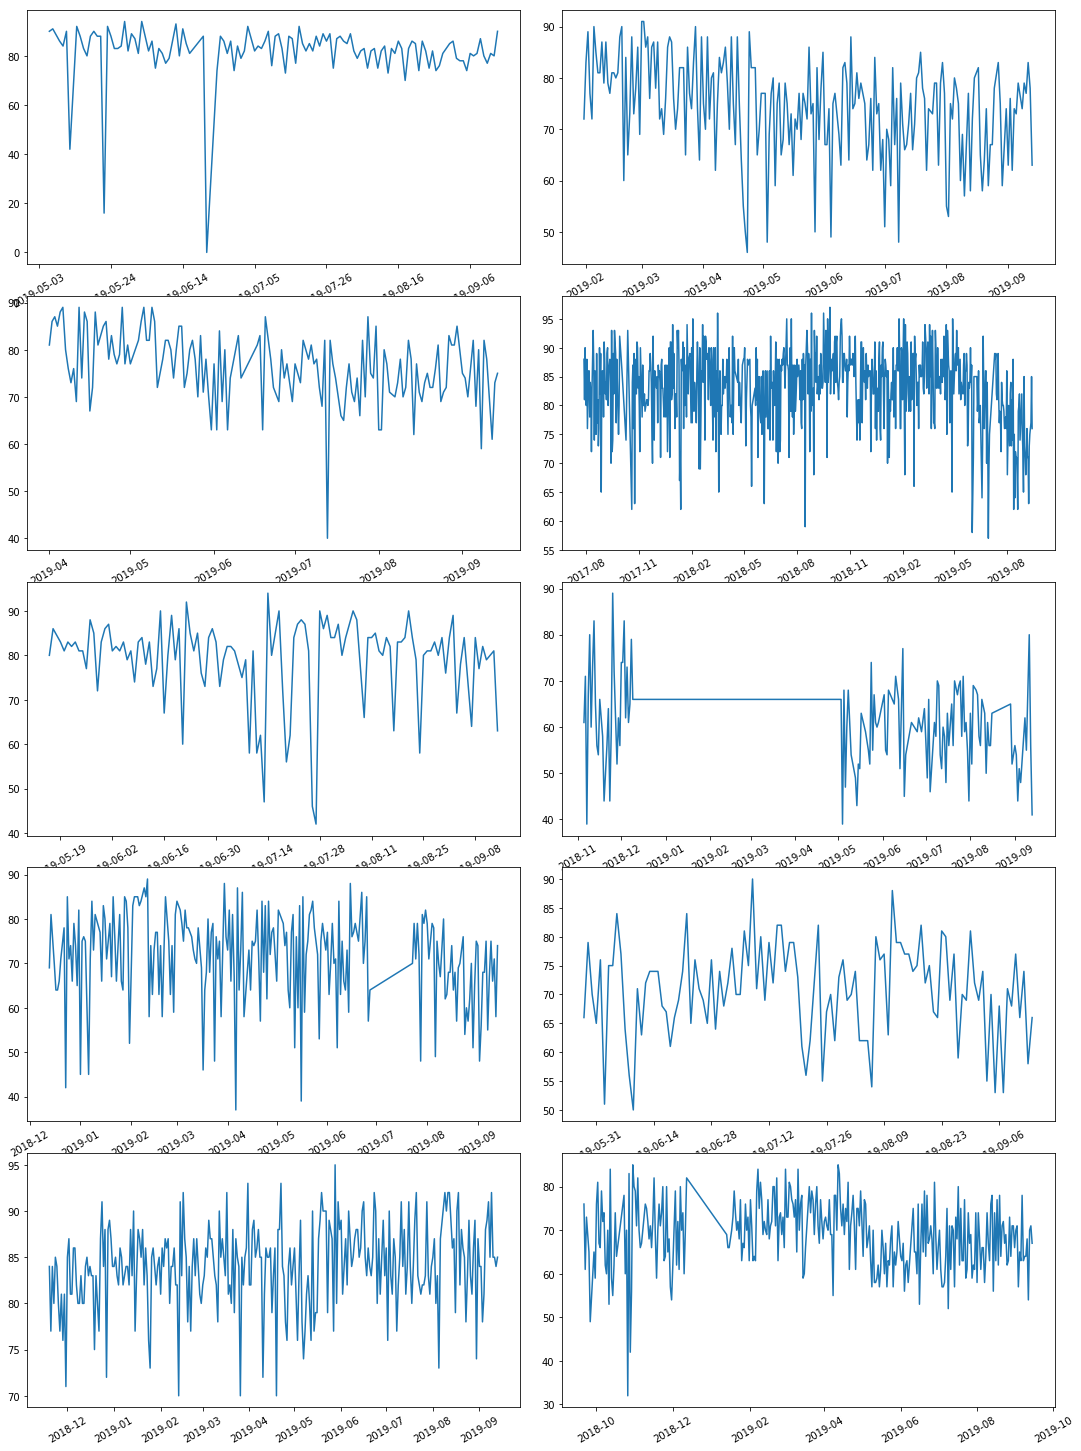

In [20]:
user_array = np.random.choice(df['user_id[str]'].unique(), 10, replace=False)


fig, ax = plt.subplots(5,2,figsize=(15,20))
plt.tight_layout()

for count, user in enumerate(user_array):
    r = count//2
    if count%2 <1:
        c = 0
    else:
        c = 1
    user_plot = df[df['user_id[str]'] == user]
    x = user_plot['summary_date[t]']
    y = user_plot['score[%]']
    
    ax[r,c].axes.xaxis_date
    plt.setp(ax[r,c].xaxis.get_majorticklabels(), rotation=30)
    ax[r,c].plot(x,y)

plt.show()

Apparently no correlations are seen, now let's run the autocorrelation analysis:

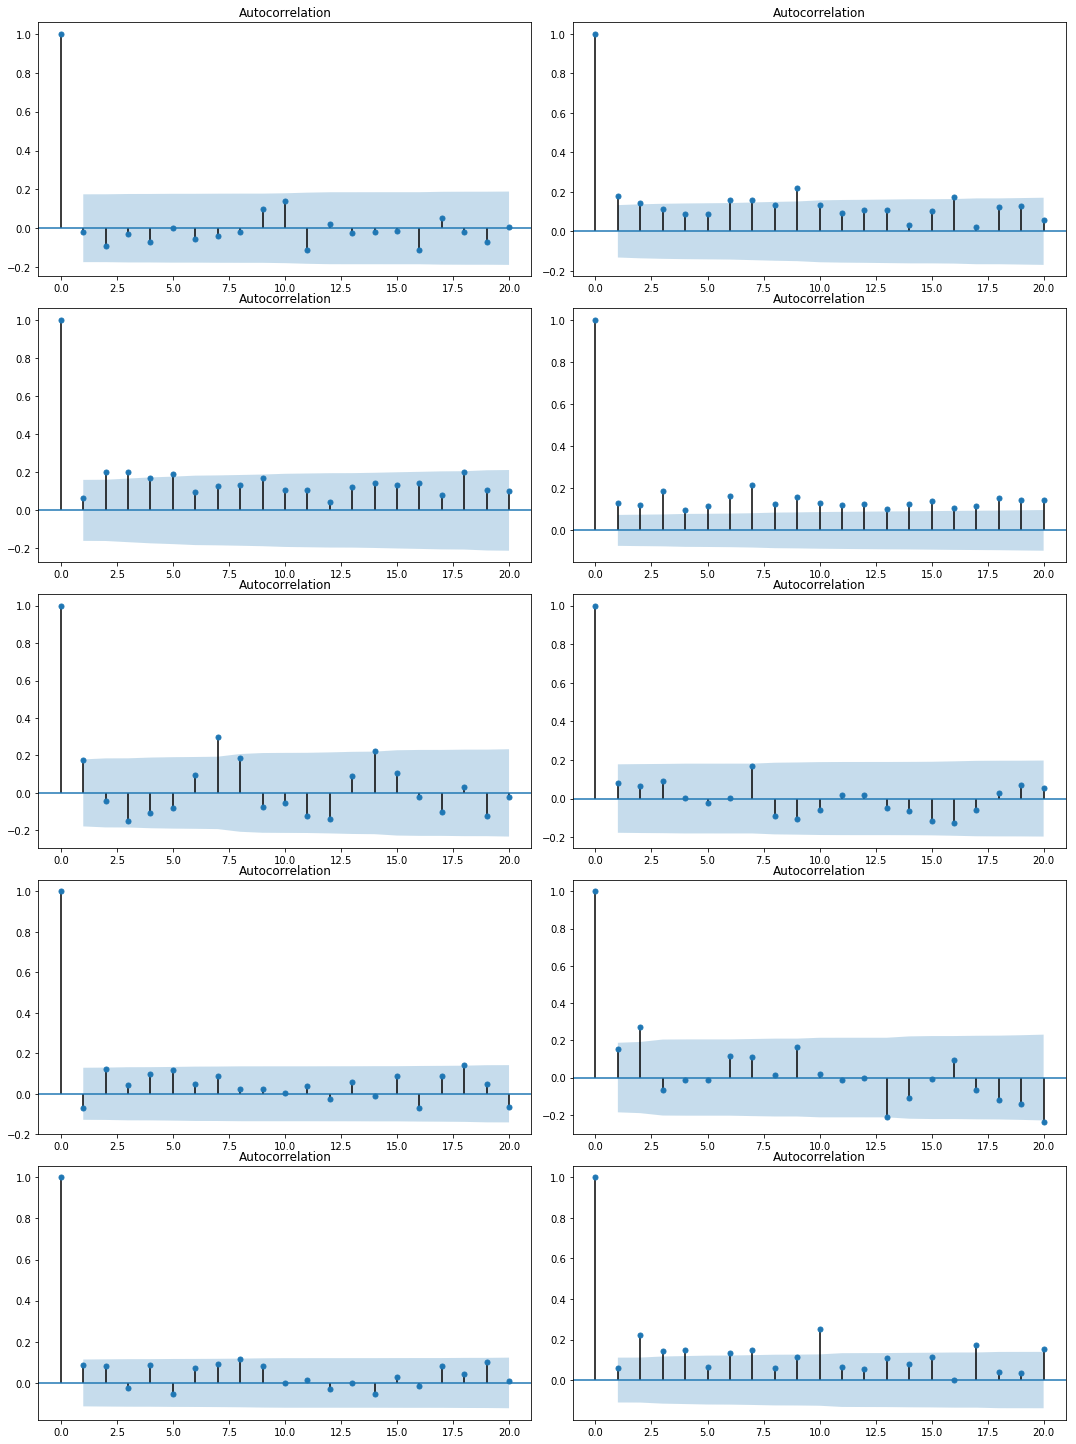

In [21]:
fig2, ax2 = plt.subplots(5,2,figsize=(15,20))
plt.tight_layout()

for count, user in enumerate(user_array):
    r = count//2
    if count%2 <1:
        c = 0
    else:
        c = 1
        
    user_plot = df[df['user_id[str]'] == user]
    plot_acf(user_plot['score[%]'], ax=ax2[r,c], lags=20)

plt.show()

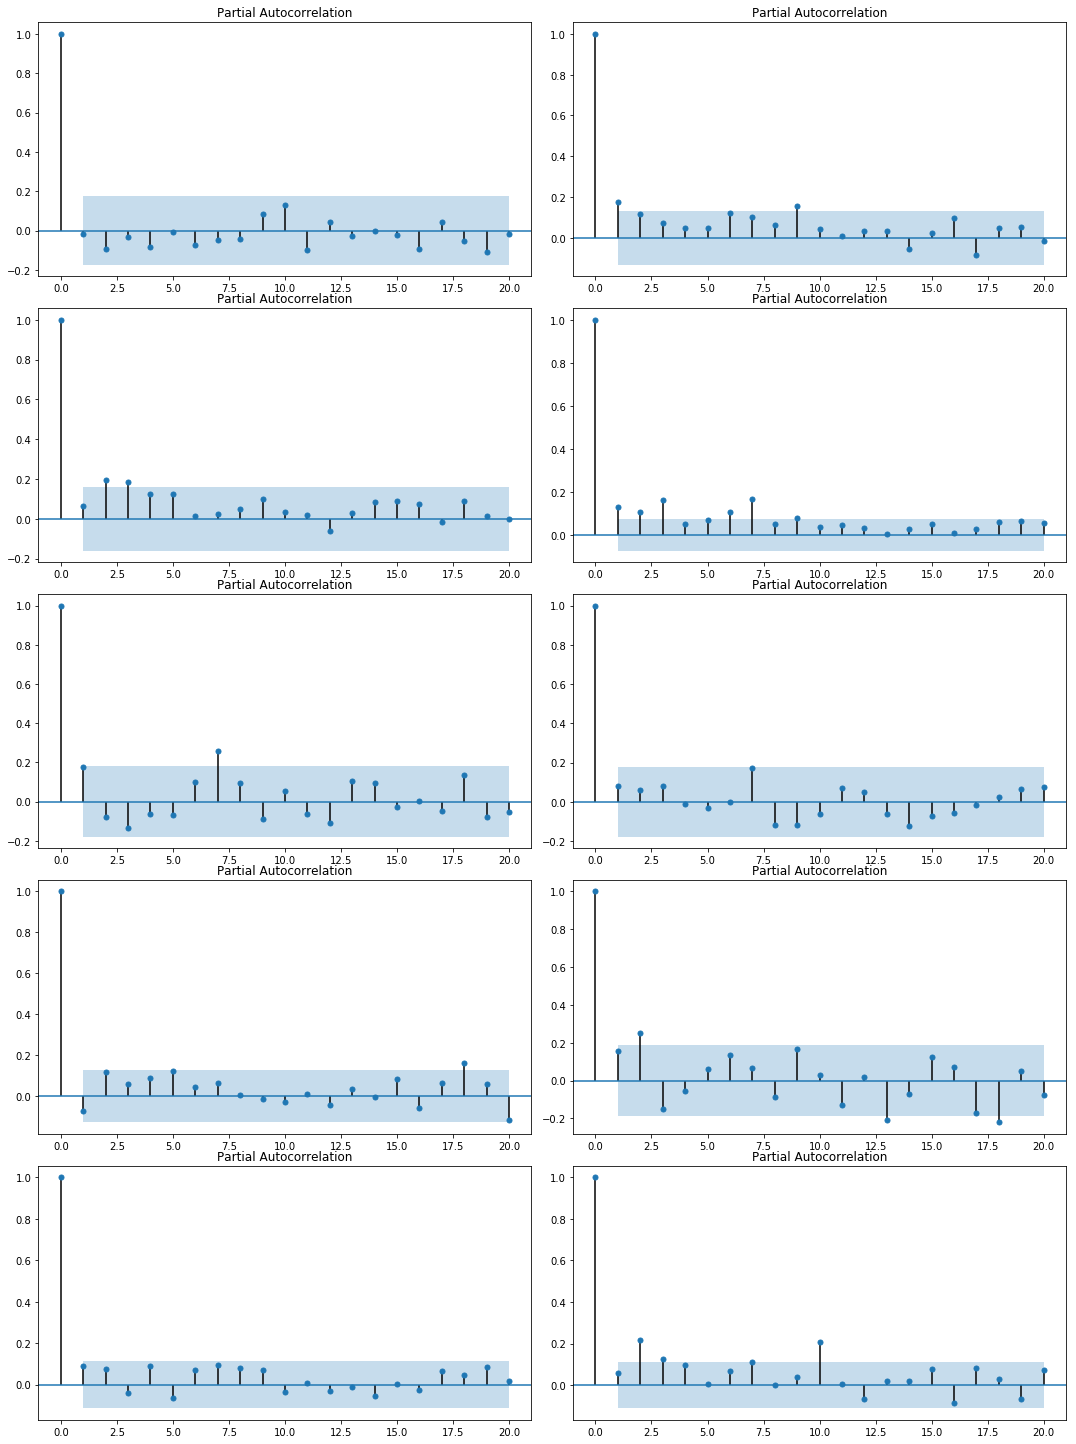

In [22]:
fig3, ax3 = plt.subplots(5,2,figsize=(15,20))
plt.tight_layout()

for count, user in enumerate(user_array):
    r = count//2
    if count%2 <1:
        c = 0
    else:
        c = 1
        
    user_plot = df[df['user_id[str]'] == user]
    plot_pacf(user_plot['score[%]'], ax=ax3[r,c], lags=20)

plt.show()

We see that, in some cases the previous 2 days would be correlated with the current score, however it is not true for all sampled users. One interesting effect is that for multiple users the correlations at day D-7 were higher than the others, suggesting an impact of the day of the week in the sleeping patterns and score.

When analyzing the partial correlation charts we still notice again the D-7 effect presence, reinforcing the idea of using weekdays as features.

Finally, we see how different are the charts for the sampled users, indicating that some are capable of following routines that can improve the sleep score.

Based on those topics, we decided to create features that are averages of the users last 7, 14, and 21 days, expecting to extract longer term trends. Another idea is to add the days of the week based on summary date (or the `bedtime_start` date), given that the time to go to bed is more related to the duration of the night sleep, as stated by Oura.

## Timezones

One idea the group had was to estimate sunlight exposure the user had. This can be estimated by the time the user had activites and the sunrise/sunset at his location. We considered assuming all users were at the USA, with timezones ranging from UTC-10 (or -600 minutes, in Hawaii) to UTC-4 (or -240 minutes, in Eastern Daylight Time). However, the distribution of our timezones shows that a significant part of the users are not in this timezones, therefore the assumption would be invalid.

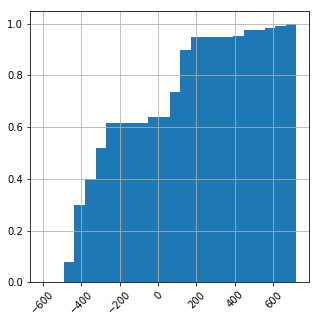

count    14189.000000
mean      -161.795757
std        286.167506
min       -600.000000
25%       -420.000000
50%       -300.000000
75%        120.000000
max        720.000000
Name: timezone[s], dtype: float64

In [23]:
hist = df['timezone[s]'].hist(figsize=(5,5), bins=24, cumulative = True, density = 'Stacked')
plt.xticks(rotation=45)
plt.show()
df['timezone[s]'].describe()

Based on the distribution below, we see that days where people were using the ring within the American timezones account for 50% to 60% of our userdays, therefore we won't use this to infer sunrise.

## Is Traveling?

One case can be when users travel a lot (which would justify buying a sleeping hygiene device). Let's check how much the users shift timezones:

In [24]:
users_tz = pd.DataFrame(df.groupby(['user_id[str]'])['timezone[s]'].value_counts(normalize=True))
users_tz

timezone[s]
user_id[str]                     timezone[s]             
3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4  60             0.466216
                                  0              0.320946
                                  180            0.141892
                                 -480            0.040541
                                  300            0.020270
                                  120            0.010135
5NG5XEFS7SLWT4LUSCW4THSFO75SIWJ6  480            1.000000
5YBPCHZWQV7Z3M2EHKJQR7VKKU4ZAABR -300            0.510934
                                 -360            0.489066
665MWIP5V5RKSFKZJJ5RCINMDJVHQPYN -420            0.786585
                                 -480            0.170732
                                  60             0.042683
75WRTQXVS7L5PLQ745ZJCKHI2YNBZU6Y  120            0.832000
                                  180            0.128000
                                  480            0.032000
                                  60             0.008000
7EH7LJ2LATLAG4XXGGB4BJB6PV2HUJH5 -360            0.569476
                                 -420            0.395216
                                 -300            0.026196
                                  120            0.009112
7RODD5JSZEB5LD3QLYLL6UAP5Q6ALPVB -240            1.000000
7YE7DHNBZC7OHB4HLMGCV5TRM5QM4OYM -300            0.644295
                                 -360            0.355705
ASAPPLHTMSEL7FWS5PFSDXOISXCUK3RN  120            0.904762
                                 -420            0.053571
                                  60             0.041667
AXDFBGOBVJ2XQMQ5VJNBGWU6EJZWB56H -420            0.637931
                                 -480            0.267241
                                  480            0.094828
BKSOOPTP226CTULYPCFRY6UJQUVAP44W  180            0.608696
...                                                   ...
TAA3QDDZ4Y66YDRTZTVDWR7ELOUD7YBR -420            0.638537
                                 -480            0.316456
                                 -600            0.015471
                                  60             0.011252
                                 -300            0.007032
                                 -240            0.007032
                                 -360            0.004219
TE2CPSSWP4QUGFAJQZ5FHITIKPNCCICX -420            0.770642
                                 -480            0.169725
                                  60             0.027523
                                 -300            0.018349
                                 -240            0.013761
TNW7YYC4H2VYZRDXQRTHMGQJZSSUHM6X  120            0.398524
                                 -480            0.309963
                                 -420            0.243542
                                 -300            0.033210
                                 -360            0.014760
TOCZTTWDTEIXG76C2FLILMGT3TTWW2CQ  120            1.000000
UZNLIVG56OJ2YYIUWHQZ4IOPJ7YBSEOE  120            0.617834
                                  60             0.382166
VCFFO3Z4VIZBSW4ZDKS7JDWPI2JFMLH7  120            0.510274
                                  60             0.458904
                                 -420            0.027397
                                 -300            0.003425
X4B2PWSKOJKCIJC3JU7W4QW3AKNWXA7T  120            1.000000
XOWSWJZCSJLOMLNS7EN5BEAIDEJFJXKF -360            1.000000
XYVULCP6S5EMI5JU2LCELQ6NMPAXOS2A  120            0.511278
                                  60             0.481203
                                  240            0.007519
ZCJQTLO5JAXRAI63MNUHG2GVOWG6JKMS  720            1.000000

[155 rows x 1 columns]

We see that a considerable amount of users shift timezones a lot, so we will add a boolean variable `is_traveling` that will be true case the user is out of his most used timezone (mode of `timezone[s]`).

## Workdays vs weekends

To get workdays, let's not consider possible national holidays and stick to Monday to Friday as workdays and Saturdays and Sundays as weekends. 

In [25]:
# build dummy to day of the week.
df['weekday[cat]'] = df['summary_date[t]'].dt.weekday

# build is_workday
df['is_workday[bool]'] = np.where(df['weekday[cat]'] < 5, True, False)

# one-hot encode weekdays
df = pd.get_dummies(df, columns=['weekday[cat]'])

df.rename(columns = {'weekday[cat]_0':'weekday_mon[bool]', 
                          'weekday[cat]_1':'weekday_tue[bool]', 
                          'weekday[cat]_2': 'weekday_wed[bool]',
                          'weekday[cat]_3': 'weekday_thu[bool]',
                          'weekday[cat]_4': 'weekday_fri[bool]',
                          'weekday[cat]_5': 'weekday_sat[bool]',
                          'weekday[cat]_6': 'weekday_sun[bool]'}, 
                          inplace = True)

## Bed time start 

In our readings, we seen that having routines on time to go to bed are benefficial to the users. in despite of finding no literature on an optimal time to go sleep, let's test it against sleep score in a simple scatter plot:

In [26]:
df[['bedtime_start[str]','bedtime_start_delta[s]', 'bedtime_end[str]', 'bedtime_end_delta[s]', 'summary_date[t]']].sample(10)

,bedtime_start[str],bedtime_start_delta[s],bedtime_end[str],bedtime_end_delta[s],summary_date[t]
3841,2019-08-01T23:53:43+02:00,-377,2019-08-02T08:21:43+02:00,30103,2019-08-01
7019,2019-09-10T22:51:53-06:00,-4087,2019-09-11T06:00:53-06:00,21653,2019-09-10
8476,2019-05-12T22:46:59-04:00,-4381,2019-05-13T08:56:59-04:00,32219,2019-05-12
4862,2019-02-24T23:50:58Z,-542,2019-02-25T07:03:58Z,25438,2019-02-24
3165,2019-07-22T01:43:58-07:00,6238,2019-07-22T07:43:58-07:00,27838,2019-07-21
258,2019-08-08T01:59:50+01:00,7190,2019-08-08T11:00:50+01:00,39650,2019-08-07
5940,2018-12-30T00:33:37-05:00,2017,2018-12-30T10:07:37-05:00,36457,2018-12-29
1958,2019-02-26T22:37:13-07:00,-4967,2019-02-27T06:13:13-07:00,22393,2019-02-26
9122,2019-08-18T23:04:30+01:00,-3330,2019-08-19T06:58:30+01:00,25110,2019-08-18
2310,2019-05-04T00:12:47-05:00,767,2019-05-04T07:30:47-05:00,27047,2019-05-03


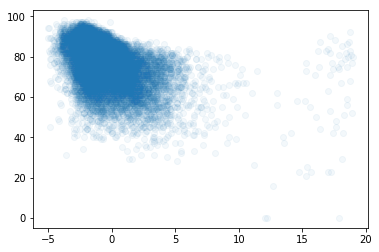

In [27]:
plt.scatter(x=df['bedtime_start_delta[s]']/3600, y=df['score[%]'], alpha=0.05)
plt.show()

Apparently there is a possible correlation there, according to our diagram the `bedtime_start` is well correlated with age. Let's start testing that with a sample group of users:

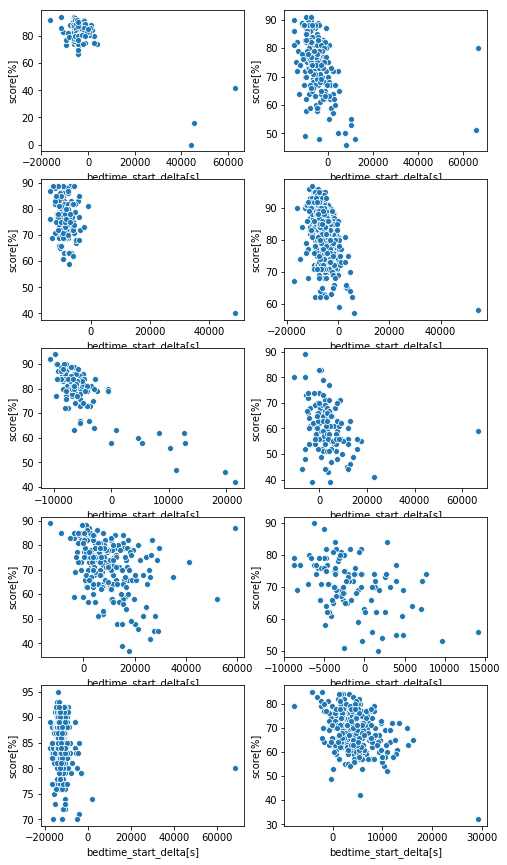

In [28]:
fig4, ax4 = plt.subplots(5,2,figsize=(8,15))

# using the same users ploted before:
for count, user in enumerate(user_array):
    r = count//2
    if (count/2).is_integer():
        c = 0
    else:
        c += 1 
    
    user_plot = df[df['user_id[str]'] == user]
    x = user_plot['bedtime_start_delta[s]']
    y = user_plot['score[%]']
    
    sns.scatterplot(x = 'bedtime_start_delta[s]', y = 'score[%]',data = user_plot, ax=ax4[r, c])   
    
plt.show()

There seems to be a pretty a general trend that, when going to bed late, the sleep score is lower (with some users being more inflenced than other). But we see that the value 0, i.e. going to bed at midnight, translates to different scores for different users. For this reason, instead of a `avg_bedtime_start` we will use a dummy variable, which indicates the deviation of going to bed for a given day in standard deviations of the avg bedtime.

Following the same idea, we will create a deviation variable for the average bedtime end delta from the previous day.

## Building user dependent features

All features depend on the aggregation by user, so all of them will be build at once, iterating over our user dataset.

In [29]:
# let start with a new dataframe:
nf_df = pd.DataFrame(columns=df.columns.append(pd.Index(['score_D-1[%]', 'score_D-2[%]', 'rol_score_7d[%]', 'rol_score_14d[%]',
                                                         'rol_score_21d[%]', 'is_traveling[bool]', 
                                                         'bedtime_start_dev-3[bool]', 'bedtime_start_dev-2[bool]',
                                                         'bedtime_start_dev-1[bool]', 'bedtime_start_dev+1[bool]', 
                                                         'bedtime_start_dev+2[bool]', 'bedtime_start_dev+3[bool]',
                                                         'bedtime_end_dev-3[bool]', 'bedtime_end_dev-2[bool]',
                                                         'bedtime_end_dev-1[bool]', 'bedtime_end_dev+1[bool]',
                                                         'bedtime_end_dev+2[bool]', 'bedtime_end_dev+3[bool]',
                                                         'duration_dev-3[bool]', 'duration_dev-2[bool]', 'duration_dev-1[bool]',
                                                         'duration_dev+1[bool]', 'duration_dev+2[bool]', 'duration_dev+3[bool]'])))

# now calculating the a features for each user and appending to the new dataset
for user in df['user_id[str]'].unique():
    # setting summary date as index to make rolling averages easier.
    single_user_df = df[df['user_id[str]'] == user]
    single_user_df.set_index('summary_date[t]', inplace = True)
    
    # build D - 1 and D - 2 scores:
    single_user_df['score_D-1[%]'] = single_user_df['score[%]'].shift()[single_user_df.index.shift(1,freq='1D')]
    single_user_df['score_D-2[%]'] = single_user_df['score[%]'].shift()[single_user_df.index.shift(1,freq='2D')]
    
    # build 7, 14, and 21 roling averega scores:
    single_user_df['rol_score_7d[%]'] = pd.rolling_mean(single_user_df['score[%]'].shift(1, freq='1D'), window=7, min_periods=3)
    single_user_df['rol_score_14d[%]'] = pd.rolling_mean(single_user_df['score[%]'].shift(1, freq='1D'), window=14, min_periods=10)
    single_user_df['rol_score_21d[%]'] = pd.rolling_mean(single_user_df['score[%]'].shift(1, freq='1D'), window=21, min_periods=17)
    
    # build is_traveling
    single_user_df['is_traveling[bool]'] = np.where(single_user_df['timezone[s]'] == 
                                                    single_user_df['timezone[s]'].value_counts().idxmax(), False, True)
    
    # build rol_bedtime_start_21d[s]
    single_user_df['rol_bedtime_start_21d[s]'] = pd.rolling_mean(single_user_df['bedtime_start_delta[s]'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10)
    
    # build avg_bedtime_start_delta, create dummy variables for deviation (-3, -2, -1, 1, 2, 3)
    single_user_df['rol_bedtime_start_std_21d[s]'] = pd.rolling_std(single_user_df['bedtime_start_delta[s]'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10)
    
    single_user_df['bedtime_start_dev[std]'] = (single_user_df['bedtime_start_delta[s]'] - single_user_df['rol_bedtime_start_21d[s]'])/single_user_df['rol_bedtime_start_std_21d[s]']
    
    single_user_df['bedtime_start_dev[std]'] = np.where(single_user_df['bedtime_start_dev[std]'] >= 0, 
                                                        np.ceil(single_user_df['bedtime_start_dev[std]']),
                                                        np.floor(single_user_df['bedtime_start_dev[std]']))
    # cap standard deviations to -3 or +3:
    single_user_df['bedtime_start_dev[std]'] = np.where(single_user_df['bedtime_start_dev[std]'] <= -3,-3,
                                                        single_user_df['bedtime_start_dev[std]'])
    
    single_user_df['bedtime_start_dev[std]'] = np.where(single_user_df['bedtime_start_dev[std]'] >= 3,3,
                                                        single_user_df['bedtime_start_dev[std]'])
    
    single_user_df = pd.get_dummies(single_user_df, columns=['bedtime_start_dev[std]'])
    
    single_user_df.rename(columns = { 'bedtime_start_dev[std]_-3.0':'bedtime_start_dev-3[bool]', 
                                      'bedtime_start_dev[std]_-2.0':'bedtime_start_dev-2[bool]', 
                                      'bedtime_start_dev[std]_-1.0': 'bedtime_start_dev-1[bool]',
                                      'bedtime_start_dev[std]_1.0': 'bedtime_start_dev+1[bool]',
                                      'bedtime_start_dev[std]_2.0': 'bedtime_start_dev+2[bool]',
                                      'bedtime_start_dev[std]_3.0': 'bedtime_start_dev+3[bool]'},
                                      inplace = True)
    
    single_user_df.drop(labels = ['rol_bedtime_start_21d[s]','rol_bedtime_start_std_21d[s]'], axis = 1, inplace = True)
    
    # build avg_bedtime_end_delta, create dummy variables for deviation. (-3, -2, -1, 1, 2, 3)
    single_user_df['rol_bedtime_end_21d[s]'] = pd.rolling_mean(single_user_df['bedtime_end_delta[s]'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10)

    single_user_df['rol_bedtime_end_std_21d[s]'] = pd.rolling_std(single_user_df['bedtime_end_delta[s]'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10)

    single_user_df['bedtime_end_dev[std]'] = (single_user_df['bedtime_end_delta[s]'] - single_user_df['rol_bedtime_end_21d[s]'])/single_user_df['rol_bedtime_end_std_21d[s]']

    single_user_df['bedtime_end_dev[std]'] = np.where(single_user_df['bedtime_end_dev[std]'] >= 0, 
                                                        np.ceil(single_user_df['bedtime_end_dev[std]']),
                                                        np.floor(single_user_df['bedtime_end_dev[std]']))
    # cap standard deviations to -3 or +3:
    single_user_df['bedtime_end_dev[std]'] = np.where(single_user_df['bedtime_end_dev[std]'] <= -3,-3,
                                                        single_user_df['bedtime_end_dev[std]'])

    single_user_df['bedtime_end_dev[std]'] = np.where(single_user_df['bedtime_end_dev[std]'] >= 3,3,
                                                        single_user_df['bedtime_end_dev[std]'])

    single_user_df = pd.get_dummies(single_user_df, columns=['bedtime_end_dev[std]'])

    single_user_df.rename(columns = {'bedtime_end_dev[std]_-3.0':'bedtime_end_dev-3[bool]', 
                              'bedtime_end_dev[std]_-2.0':'bedtime_end_dev-2[bool]', 
                              'bedtime_end_dev[std]_-1.0': 'bedtime_end_dev-1[bool]',
                              'bedtime_end_dev[std]_1.0': 'bedtime_end_dev+1[bool]',
                              'bedtime_end_dev[std]_2.0': 'bedtime_end_dev+2[bool]',
                              'bedtime_end_dev[std]_3.0': 'bedtime_end_dev+3[bool]'},
                              inplace = True)

    single_user_df.drop(labels = ['rol_bedtime_end_21d[s]','rol_bedtime_end_std_21d[s]'], axis = 1, inplace = True)
    
    # build avg_duration, create dummy variables for deviation (-3, -2, -1, 1, 2, 3)
    single_user_df['rol_duration_21d[s]'] = pd.rolling_mean(single_user_df['duration[s]'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10)

    single_user_df['rol_duration_std_21d[s]'] = pd.rolling_std(single_user_df['duration[s]'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10)

    single_user_df['duration_dev[std]'] = (single_user_df['duration[s]'] - single_user_df['rol_duration_21d[s]'])/single_user_df['rol_duration_std_21d[s]']

    single_user_df['duration_dev[std]'] = np.where(single_user_df['duration_dev[std]'] >= 0, 
                                                        np.ceil(single_user_df['duration_dev[std]']),
                                                        np.floor(single_user_df['duration_dev[std]']))
    # cap standard deviations to -3 or +3:
    single_user_df['duration_dev[std]'] = np.where(single_user_df['duration_dev[std]'] <= -3,-3,
                                                        single_user_df['duration_dev[std]'])

    single_user_df['duration_dev[std]'] = np.where(single_user_df['duration_dev[std]'] >= 3,3,
                                                        single_user_df['duration_dev[std]'])

    single_user_df = pd.get_dummies(single_user_df, columns=['duration_dev[std]'])

    single_user_df.rename(columns = {'duration_dev[std]_-3.0':'duration_dev-3[bool]', 
                              'duration_dev[std]_-2.0':'duration_dev-2[bool]', 
                              'duration_dev[std]_-1.0':'duration_dev-1[bool]',
                              'duration_dev[std]_1.0': 'duration_dev+1[bool]',
                              'duration_dev[std]_2.0': 'duration_dev+2[bool]',
                              'duration_dev[std]_3.0': 'duration_dev+3[bool]'},
                              inplace = True)

    single_user_df.drop(labels = ['rol_duration_21d[s]','rol_duration_std_21d[s]'], axis = 1, inplace = True)
    
    # reset index to be user_date[str]
    single_user_df.set_index('user_date[str]', inplace = True)
    
    # create a new dataset with the new variables
    nf_df = nf_df.append(single_user_df)
    

/Users/marceloqueiroz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/marceloqueiroz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/marceloqueiroz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=3,center=False).mean()
/Users/marceloqueiroz/anacond

In [30]:
print('New DF shape: ', nf_df.shape)
print('New DF Columns:')
nf_df.columns

New DF shape:  (14189, 75)
New DF Columns:


Index(['age[y]', 'awake[s]', 'bedtime_end[str]', 'bedtime_end_delta[s]',
       'bedtime_end_dev+1[bool]', 'bedtime_end_dev+2[bool]',
       'bedtime_end_dev+3[bool]', 'bedtime_end_dev-1[bool]',
       'bedtime_end_dev-2[bool]', 'bedtime_end_dev-3[bool]',
       'bedtime_start[str]', 'bedtime_start_delta[s]',
       'bedtime_start_dev+1[bool]', 'bedtime_start_dev+2[bool]',
       'bedtime_start_dev+3[bool]', 'bedtime_start_dev-1[bool]',
       'bedtime_start_dev-2[bool]', 'bedtime_start_dev-3[bool]',
       'breath_average[breath/min]', 'deep[s]', 'duration[s]',
       'duration_dev+1[bool]', 'duration_dev+2[bool]', 'duration_dev+3[bool]',
       'duration_dev-1[bool]', 'duration_dev-2[bool]', 'duration_dev-3[bool]',
       'efficiency[%]', 'gender', 'height[cm]', 'hr_5min[bpm]',
       'hr_average[bpm]', 'hr_lowest[bpm]', 'hypnogram_5min[str]',
       'is_longest[bool]', 'is_traveling[bool]', 'is_workday[bool]',
       'light[s]', 'midpoint_at_delta[s]', 'midpoint_time[s]',
       'on

In [31]:
nf_df.sample(5)

,age[y],awake[s],bedtime_end[str],bedtime_end_delta[s],bedtime_end_dev+1[bool],bedtime_end_dev+2[bool],bedtime_end_dev+3[bool],bedtime_end_dev-1[bool],bedtime_end_dev-2[bool],bedtime_end_dev-3[bool],...,user_date[str],user_id[str],weekday_fri[bool],weekday_mon[bool],weekday_sat[bool],weekday_sun[bool],weekday_thu[bool],weekday_tue[bool],weekday_wed[bool],weight[kg]
JTSGXI32MOLULL3YCXQG7Q6NDRFP22YQ_2019-08-25,44.0,4320,2019-08-26T08:17:31-06:00,29851,1,0,0,0,0,0,...,NaN,JTSGXI32MOLULL3YCXQG7Q6NDRFP22YQ,0,0,0,1,0,0,0,72.9
COFYOGC575GXUOYHBTBV7AUC6WUPFPGE_2019-08-08,44.0,2640,2019-08-09T06:54:24-04:00,24864,0,0,0,1,0,0,...,NaN,COFYOGC575GXUOYHBTBV7AUC6WUPFPGE,0,0,0,0,1,0,0,75.0
RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM_2019-03-08,21.0,7980,2019-03-09T08:26:15-08:00,30375,0,0,0,0,0,0,...,NaN,RL55LUCNRL6X4ESUQUTPNE3ZT3TX3LFM,1,0,0,0,0,0,0,68.0
CCDHHTNYOR4KECZI2PVPTT7VBWV22KRJ_2019-07-15,41.0,6960,2019-07-16T05:52:01-07:00,21121,0,0,0,1,0,0,...,NaN,CCDHHTNYOR4KECZI2PVPTT7VBWV22KRJ,0,1,0,0,0,0,0,90.7
NFDXWWBOEYFFXYZ7YXWCX3JUADIJCOVE_2019-05-05,49.0,750,2019-05-06T05:45:39-07:00,20739,0,0,0,1,0,0,...,NaN,NFDXWWBOEYFFXYZ7YXWCX3JUADIJCOVE,0,0,0,1,0,0,0,64.9
